<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/RNN_IMDB_step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# RNN paso a paso con IMDB (sentiment analysis)
**Objetivo:** construir, entrenar y evaluar una red recurrente simple (**RNN**) para clasificar opiniones de películas (positivo/negativo) usando el dataset **IMDB**.  
Código *secuencial*, sin funciones auxiliares, con muchos comentarios.


In [1]:
# ==================================
# 0. IMPORTS Y CONFIGURACIÓN BÁSICA
# ==================================
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Semillas "básicas" para cierta reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU disponible: []


In [2]:
# ==================================
# 1. CARGA DEL DATASET (IMDB)
# ==================================
# IMDB trae reviews de películas codificadas como secuencias de enteros (palabras -> índices).
# Cada review tiene etiqueta 0 (negativo) o 1 (positivo).
# 'num_words' limita el vocabulario a las N palabras más frecuentes.

num_words = 20000    # vocabulario limitado a 20k palabras más comunes
maxlen = 200         # longitud máxima de secuencia (recortamos/paddeamos)

from tensorflow.keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

print("Número de reviews - train:", len(x_train), " test:", len(x_test))
print("Ejemplo de secuencia (primer review):", x_train[0][:20], "...")
print("Etiqueta del primer review:", y_train[0])


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Número de reviews - train: 25000  test: 25000
Ejemplo de secuencia (primer review): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25] ...
Etiqueta del primer review: 1


In [3]:
# ===================================================
# 2. DECODIFICAR ALGUNAS REVIEWS PARA "VER" EL TEXTO
# ===================================================
# IMDB da secuencias de enteros. Usamos el diccionario para ver palabras.
# Nota: índices 1..num_words están mapeados a palabras. Keras reserva:
# 0: <pad>, 1: <start>, 2: <oov>, 3: <unused>

word_index = imdb.get_word_index()
index_to_word = { (v+3): k for k, v in word_index.items() }
index_to_word[0] = "<pad>"
index_to_word[1] = "<start>"
index_to_word[2] = "<oov>"
index_to_word[3] = "<unused>"

# Decodificación de algunas reviews
for i in range(3):
    words = [index_to_word.get(j, "<oov>") for j in x_train[i][:100]]
    text = " ".join(words)
    print(f"--- Review {i} (entero -> texto) ---")
    print(text, "...")
    print("Etiqueta:", y_train[i])
    print()


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Review 0 (entero -> texto) ---
<start> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was ...
Etiqueta: 1

--- Review 1 (entero -> texto) ---
<start> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completel

In [4]:
# ==================================
# 3. PADDING/TRUNCADO Y VALIDACIÓN
# ==================================
# Aseguramos que todas las secuencias tengan la misma longitud 'maxlen'.

#PADDING = Rellenar con Ceros
#Si un texto es demasiado corto, añadimos ceros (0) al finalTRUNCADO = Cortar
#Si un texto es demasiado largo, lo cortamos

from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=maxlen, padding='pre', truncating='pre')
x_test  = pad_sequences(x_test,  maxlen=maxlen, padding='pre', truncating='pre')

# Conjunto de validación
val_size = 5000
x_val = x_train[-val_size:]
y_val = y_train[-val_size:]
x_train = x_train[:-val_size]
y_train = y_train[:-val_size]

print("x_train:", x_train.shape, "| x_val:", x_val.shape, "| x_test:", x_test.shape)


x_train: (20000, 200) | x_val: (5000, 200) | x_test: (25000, 200)


In [ ]:
#Texto 1: "Me gusta"           → [5, 8]
#Texto 2: "Es genial"          → [3, 9]
#Texto 3: "Muy bueno calidad"  → [12, 15, 20]
#Problema: Diferentes longitudes (2, 2, 3 números)
#Se decide una Longitud Máxima = 5


In [5]:
# ==================================
# 4. MODELO RNN SENCILLO (BASELINE)
# TEXTO → [EMBEDDING] → [RNN] → [DENSE] → PREDICCIÓN (0 o 1)
# ==================================

embedding_dim = 64 # Cada palabra se representa con 64 números

model = keras.Sequential()

model.add(layers.Embedding(input_dim=num_words,       # 20,000 palabras en el vocabulario
                           output_dim=embedding_dim,  # Cada palabra → 64 números
                           input_length=maxlen))      # Entrada: 200 números (palabras)

model.add(layers.SimpleRNN(64)) #Capa SimpleRNN

model.add(layers.Dense(1, activation="sigmoid")) # Capa de salida sigmoid 1 o 0

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#ANTES del Embedding:
#Input: [523, 12, 8901, 45, ...]  # 200 palabras (números simples)

#DESPUÉS del Embedding:
#Palabra 523  → [0.2, -0.5, 0.8, ..., 0.3]  # Vector de 64 números
#Palabra 12   → [0.7, 0.1, -0.3, ..., 0.9]  # Vector de 64 números
#Palabra 8901 → [-0.4, 0.6, 0.2, ..., -0.1] # Vector de 64 números

#Resultado: Una matriz de tamaño (200, 64)


In [6]:

# ========================
# 5. COMPILAR EL MODELO
# ========================

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [7]:

# ========================
# 6. ENTRENAMIENTO
# ========================
epochs = 5
batch_size = 64

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.5797 - loss: 0.6546 - val_accuracy: 0.7532 - val_loss: 0.5357
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.8353 - loss: 0.3757 - val_accuracy: 0.8274 - val_loss: 0.4050
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9118 - loss: 0.2248 - val_accuracy: 0.8160 - val_loss: 0.4844
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9589 - loss: 0.1131 - val_accuracy: 0.6316 - val_loss: 0.8514
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9458 - loss: 0.1445 - val_accuracy: 0.8016 - val_loss: 0.6805


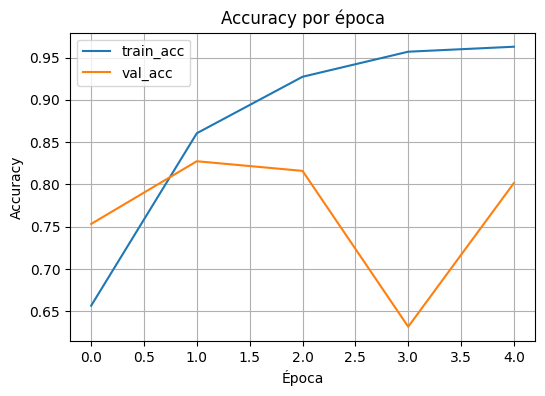

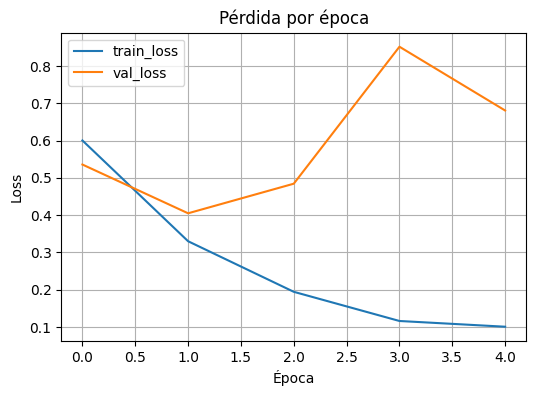

In [8]:

# ===================================
# 7. CURVAS DE ENTRENAMIENTO/VALIDACIÓN
# ===================================

# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Pérdida
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [9]:

# ========================
# 8. EVALUACIÓN EN TEST
# ========================
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Loss en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")


Loss en test: 0.6935
Accuracy en test: 0.7991


In [10]:

# ======================================
# 9. PREDICCIONES Y MUESTRA DE RESULTADOS
# ======================================
num_examples = 5
sample_x = x_test[:num_examples]
sample_y = y_test[:num_examples]

probs = model.predict(sample_x, verbose=0).reshape(-1)
pred_labels = (probs >= 0.5).astype(int)

for i in range(num_examples):
    # reconstruimos texto ignorando los <pad>=0
    nonzero = sample_x[i][sample_x[i] != 0]
    words = [index_to_word.get(idx, "<oov>") for idx in nonzero]
    text = " ".join(words)
    print("="*60)
    print("Texto (recortado a maxlen):")
    print(text[:400], "...")
    print(f"Prob. positivo: {probs[i]:.3f} | Pred: {pred_labels[i]} | Real: {sample_y[i]}")


Texto (recortado a maxlen):
<start> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss ...
Prob. positivo: 0.000 | Pred: 0 | Real: 0
Texto (recortado a maxlen):
psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael  ...
Prob. positivo: 0.963 | Pred: 1 | Real: 1
Texto (recortado a maxlen):
everyone's horror the <oov> promptly eats the mayor and then goes 


## Ideas para seguir mejorando (opcionales)
**Tres bloques** con variantes del modelo base para comparar resultados:
1) Sustituir `SimpleRNN` por **LSTM**.  
2) **Bidirectional LSTM** con `Dropout`.  
3) **ReduceLROnPlateau + EarlyStopping** para ajustar el aprendizaje automáticamente.


In [11]:

# =====================================================
# (1) SUSTITUIR SimpleRNN POR LSTM (más potente)
# =====================================================
embedding_dim = 64

model_lstm = keras.Sequential()

model_lstm.add(layers.Embedding(input_dim=num_words,
                                output_dim=embedding_dim,
                                input_length=maxlen))

model_lstm.add(layers.LSTM(64)) #aqui cambiamos a ver si mejora el modelo
model_lstm.add(layers.Dense(1, activation="sigmoid"))

model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_lstm = model_lstm.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)

test_loss, test_acc = model_lstm.evaluate(x_test, y_test, verbose=0)
print(f"[LSTM] Loss test: {test_loss:.4f} | Acc test: {test_acc:.4f}")


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 163ms/step - accuracy: 0.7092 - loss: 0.5264 - val_accuracy: 0.8738 - val_loss: 0.3096
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 155ms/step - accuracy: 0.8998 - loss: 0.2492 - val_accuracy: 0.8744 - val_loss: 0.3271
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 148ms/step - accuracy: 0.9310 - loss: 0.1832 - val_accuracy: 0.8714 - val_loss: 0.3507
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 152ms/step - accuracy: 0.9434 - loss: 0.1606 - val_accuracy: 0.8554 - val_loss: 0.4143
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.9549 - loss: 0.1328 - val_accuracy: 0.8634 - val_loss: 0.4130
[LSTM] Loss test: 0.4436 | Acc test: 0.8547
